# Generative Adversarial Networks (GANs)
So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

answers = np.load('gan-checks-tf.npz')

NOISE_DIM = 96

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [3]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

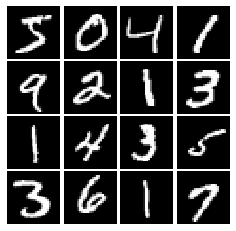

In [4]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [5]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    
    # What we want is:
    #   x * alpha if x < 0
    #   x if x > 0
    #
    # since 0 < alpha < 1, this is just max(x*alpha, x)
    
    xs = x * alpha
    return tf.maximum(x, xs)



Test your leaky ReLU implementation. You should get errors < 1e-10

In [6]:
def test_leaky_relu(x, y_true):
    y = leaky_relu(tf.constant(x))
    print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [7]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return tf.random.uniform([batch_size, dim], -1, 1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Make sure noise is the correct shape and type:

In [8]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. **Hint:** You should use the layers in `tf.keras.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.keras.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [9]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_shape = (784,)),
        tf.keras.layers.LeakyReLU(alpha = .01),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(alpha = .01),
        tf.keras.layers.Dense(1)
    ])
   
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [10]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.keras.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [11]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        tf.keras.layers.Dense(1024, input_shape = (noise_dim,)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(784, activation = tf.nn.tanh),
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])

    return model

Test to make sure the number of parameters in the generator is correct:

In [12]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/ones) and [tf.zeros](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/zeros) to generate labels for your discriminator. Use [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses/BinaryCrossentropy) to help compute your loss function.

In [13]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: Tensor of shape (N, 1) giving scores for the real data.
    - logits_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Returns:
    - loss: Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
    loss = bce(tf.zeros_like(logits_fake), logits_fake)    
    loss += bce(tf.ones_like(logits_real), logits_real)    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
    loss = bce(tf.ones_like(logits_fake), logits_fake)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-8.

In [14]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    
    print ("d_loss",d_loss.numpy())
    print ("d_loss_true", d_loss_true)    
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

d_loss 1.8423984050750732
d_loss_true 1.8423983904443109
Maximum error in d_loss: 3.97058e-09


In [15]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print ("g_loss",g_loss.numpy())
    print ("g_loss_true", g_loss_true)
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

g_loss 0.7712861895561218
g_loss_true 0.771286196423346
Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
Make an `Adam` optimizer with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [16]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    D_solver = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1)
    G_solver = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1)
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [17]:
# a giant helper function
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=20, print_every=20, batch_size=128, num_epochs=10, noise_size=96):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
            
            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or about 2 minutes on GPU.

In [ ]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [18]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: Tensor of shape (N, 1) giving scores for the real data.
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    d2_real = tf.math.square(scores_real - 1)
    d2_fake = tf.math.square(scores_fake)
    
    loss = (tf.reduce_mean(d2_real) + tf.reduce_mean(d2_fake)) / 2    

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    d2 = tf.math.square(scores_fake - 1)
    
    loss = tf.reduce_mean(d2) / 2

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your LSGAN loss. You should see errors less than 1e-8.

In [19]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    
    d_loss = ls_discriminator_loss(tf.constant(score_real), tf.constant(score_fake))
    g_loss = ls_generator_loss(tf.constant(score_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))



test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])


Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

Epoch: 0, Iter: 0, D: 1.374, G:0.4263


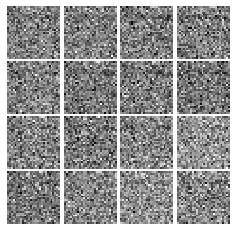

Epoch: 0, Iter: 20, D: 0.1191, G:1.312


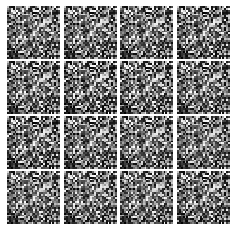

Epoch: 0, Iter: 40, D: 0.01271, G:0.7093


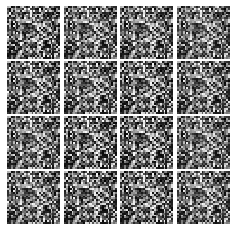

Epoch: 0, Iter: 60, D: 0.05453, G:0.7052


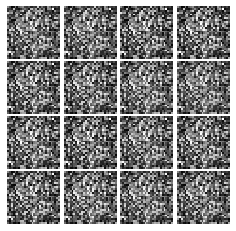

Epoch: 0, Iter: 80, D: 0.0289, G:0.5706


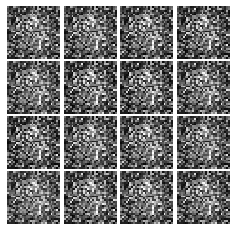

Epoch: 0, Iter: 100, D: 0.05711, G:0.4536


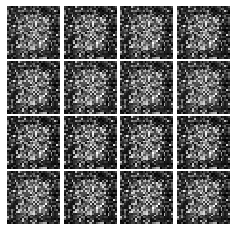

Epoch: 0, Iter: 120, D: 0.4135, G:0.1231


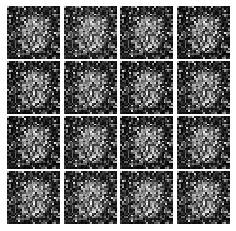

Epoch: 0, Iter: 140, D: 0.2682, G:0.6972


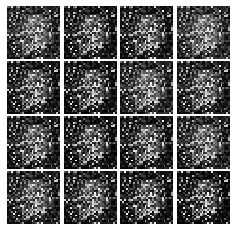

Epoch: 0, Iter: 160, D: 0.1156, G:0.4504


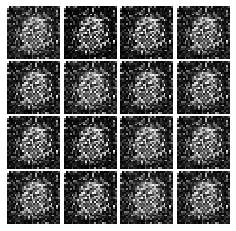

Epoch: 0, Iter: 180, D: 0.2904, G:0.3076


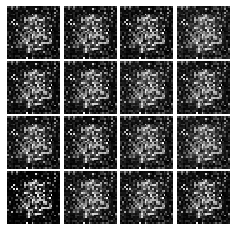

Epoch: 0, Iter: 200, D: 0.1027, G:0.578


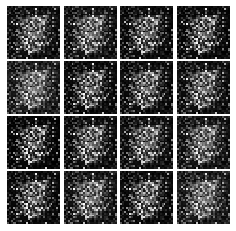

Epoch: 0, Iter: 220, D: 0.154, G:0.6526


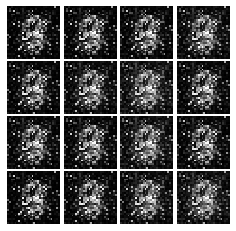

Epoch: 0, Iter: 240, D: 0.1663, G:0.09275


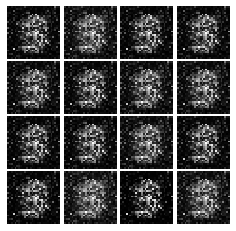

Epoch: 0, Iter: 260, D: 0.1021, G:0.4636


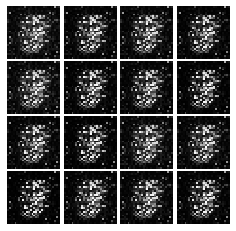

Epoch: 0, Iter: 280, D: 0.08956, G:0.445


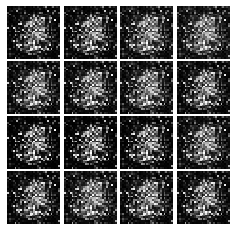

Epoch: 0, Iter: 300, D: 0.0879, G:0.4385


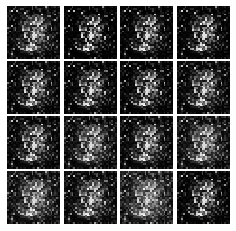

Epoch: 0, Iter: 320, D: 0.1834, G:0.4959


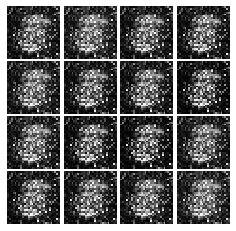

Epoch: 0, Iter: 340, D: 0.1602, G:0.3134


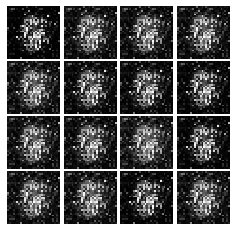

Epoch: 0, Iter: 360, D: 0.1278, G:0.7218


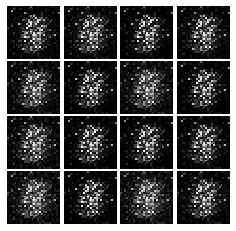

Epoch: 0, Iter: 380, D: 0.1635, G:0.4597


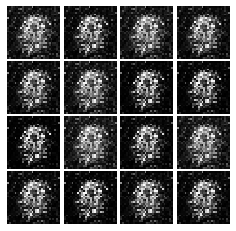

Epoch: 0, Iter: 400, D: 0.153, G:0.7057


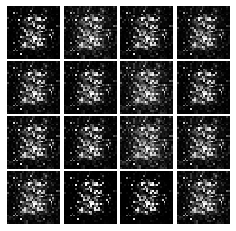

Epoch: 0, Iter: 420, D: 0.09526, G:0.5032


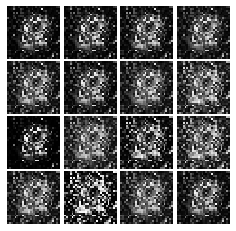

Epoch: 0, Iter: 440, D: 0.1125, G:0.2707


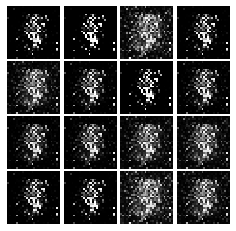

Epoch: 0, Iter: 460, D: 0.1018, G:0.5132


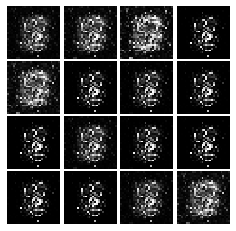

Epoch: 1, Iter: 480, D: 0.1676, G:0.4194


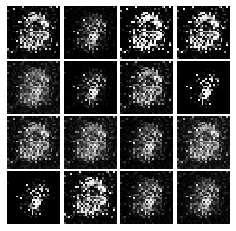

Epoch: 1, Iter: 500, D: 0.1593, G:1.016


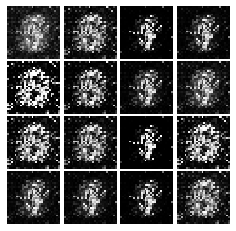

Epoch: 1, Iter: 520, D: 0.1381, G:0.6916


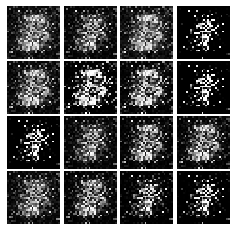

Epoch: 1, Iter: 540, D: 0.06766, G:0.3781


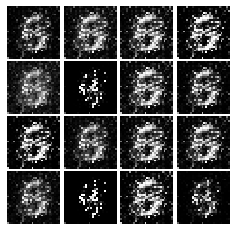

Epoch: 1, Iter: 560, D: 0.1352, G:0.703


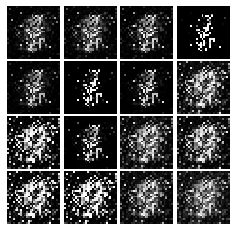

Epoch: 1, Iter: 580, D: 0.1916, G:0.02036


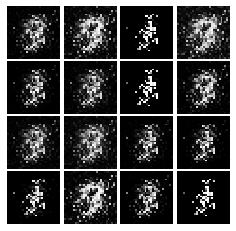

Epoch: 1, Iter: 600, D: 0.1254, G:0.3276


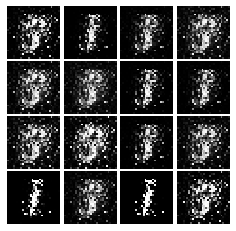

Epoch: 1, Iter: 620, D: 0.1788, G:0.1935


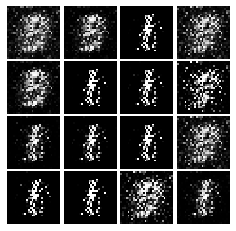

Epoch: 1, Iter: 640, D: 0.1042, G:0.4581


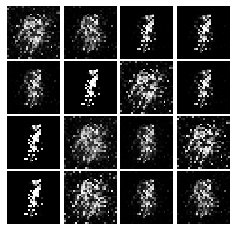

Epoch: 1, Iter: 660, D: 0.1323, G:0.3299


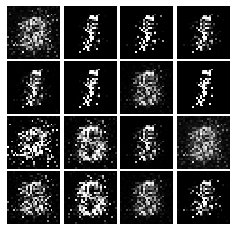

Epoch: 1, Iter: 680, D: 0.1597, G:0.6672


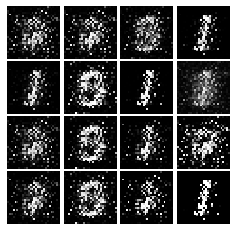

Epoch: 1, Iter: 700, D: 0.1666, G:0.6532


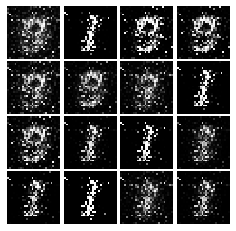

Epoch: 1, Iter: 720, D: 0.1095, G:0.9589


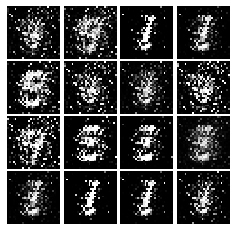

Epoch: 1, Iter: 740, D: 0.1024, G:0.4719


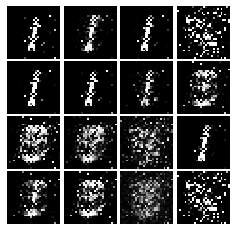

Epoch: 1, Iter: 760, D: 0.09619, G:0.3938


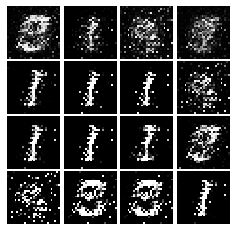

Epoch: 1, Iter: 780, D: 0.534, G:0.6265


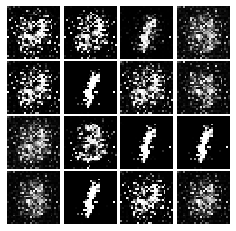

Epoch: 1, Iter: 800, D: 0.1173, G:0.3727


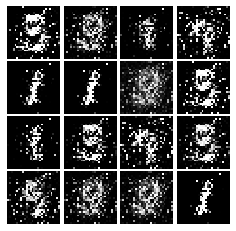

Epoch: 1, Iter: 820, D: 0.2034, G:0.56


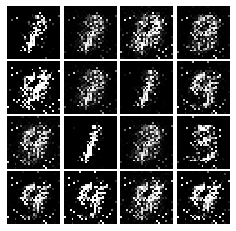

Epoch: 1, Iter: 840, D: 0.42, G:0.4621


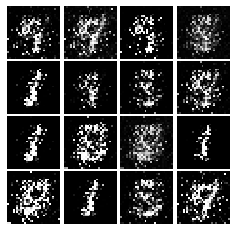

Epoch: 1, Iter: 860, D: 0.1986, G:0.2816


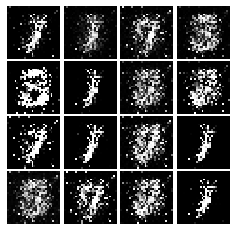

Epoch: 1, Iter: 880, D: 0.2876, G:0.04699


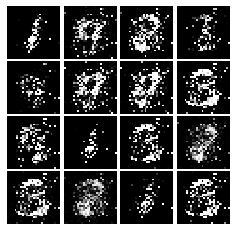

Epoch: 1, Iter: 900, D: 0.1346, G:0.2996


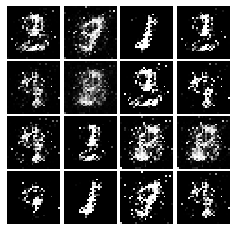

Epoch: 1, Iter: 920, D: 0.1537, G:0.2236


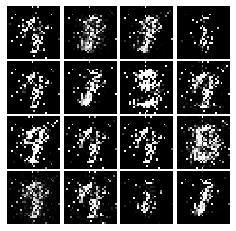

Epoch: 2, Iter: 940, D: 0.1486, G:0.4168


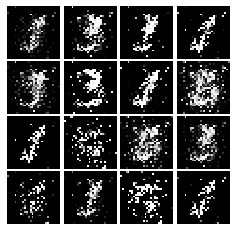

Epoch: 2, Iter: 960, D: 0.1849, G:0.5243


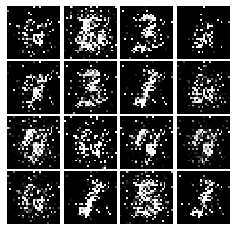

Epoch: 2, Iter: 980, D: 0.1236, G:0.355


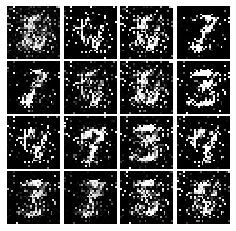

Epoch: 2, Iter: 1000, D: 0.1271, G:0.3087


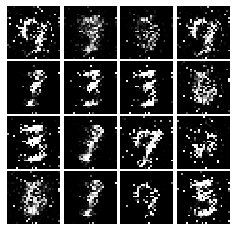

Epoch: 2, Iter: 1020, D: 0.14, G:0.429


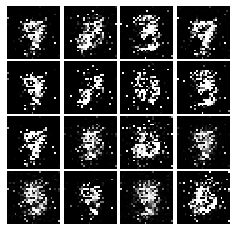

Epoch: 2, Iter: 1040, D: 0.09534, G:0.5327


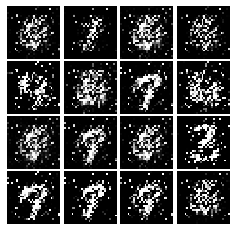

Epoch: 2, Iter: 1060, D: 0.1568, G:0.2909


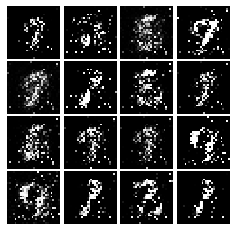

Epoch: 2, Iter: 1080, D: 0.1265, G:0.332


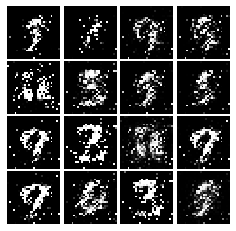

Epoch: 2, Iter: 1100, D: 0.1488, G:0.2647


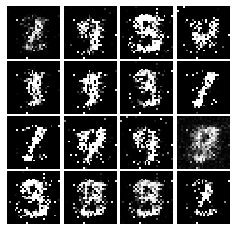

Epoch: 2, Iter: 1120, D: 0.1671, G:0.3814


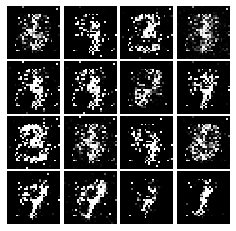

Epoch: 2, Iter: 1140, D: 0.1785, G:0.4708


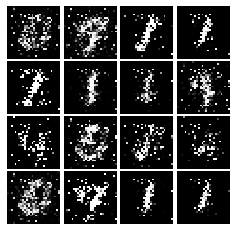

Epoch: 2, Iter: 1160, D: 0.1458, G:0.2321


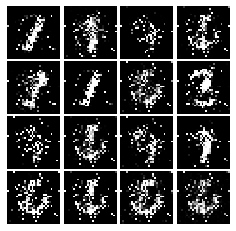

Epoch: 2, Iter: 1180, D: 0.152, G:0.4785


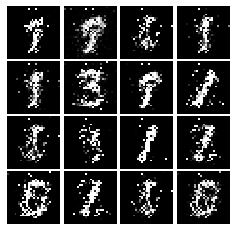

Epoch: 2, Iter: 1200, D: 0.1487, G:0.2883


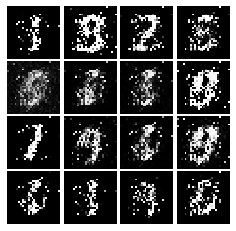

Epoch: 2, Iter: 1220, D: 0.1505, G:0.2991


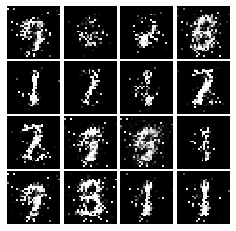

Epoch: 2, Iter: 1240, D: 0.1688, G:0.4379


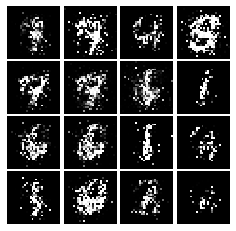

Epoch: 2, Iter: 1260, D: 0.1245, G:0.399


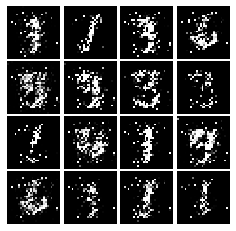

Epoch: 2, Iter: 1280, D: 0.1757, G:0.2216


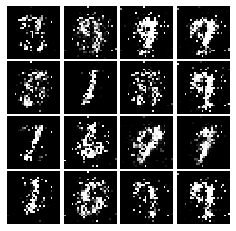

Epoch: 2, Iter: 1300, D: 0.1397, G:0.2839


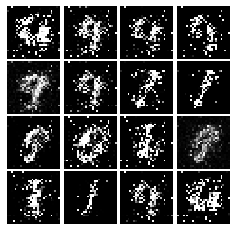

Epoch: 2, Iter: 1320, D: 0.2124, G:0.2051


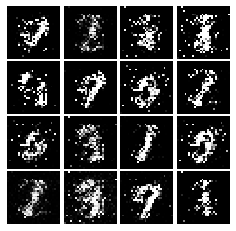

Epoch: 2, Iter: 1340, D: 0.1421, G:0.3607


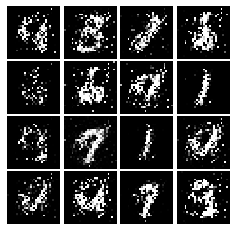

Epoch: 2, Iter: 1360, D: 0.2019, G:0.2096


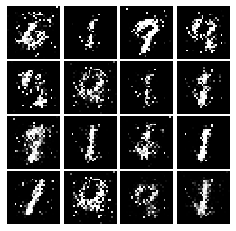

Epoch: 2, Iter: 1380, D: 0.2275, G:0.4069


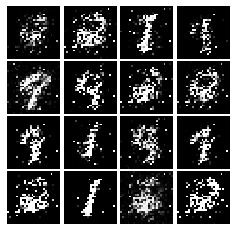

Epoch: 2, Iter: 1400, D: 0.1088, G:0.305


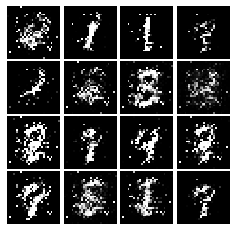

Epoch: 3, Iter: 1420, D: 0.2178, G:0.3603


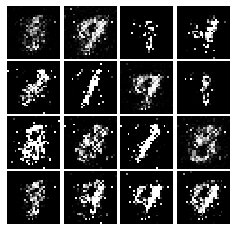

Epoch: 3, Iter: 1440, D: 0.1737, G:0.2381


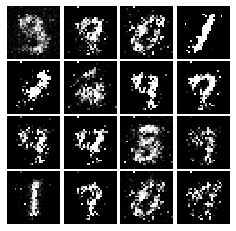

Epoch: 3, Iter: 1460, D: 0.205, G:0.2364


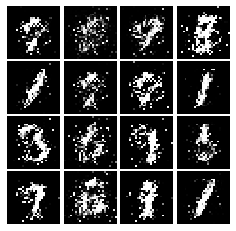

Epoch: 3, Iter: 1480, D: 0.2538, G:0.2493


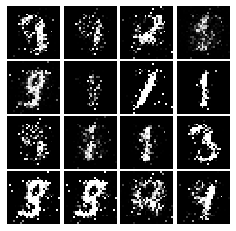

Epoch: 3, Iter: 1500, D: 0.1793, G:0.3018


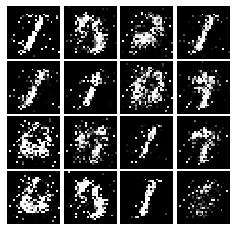

Epoch: 3, Iter: 1520, D: 0.2215, G:0.1977


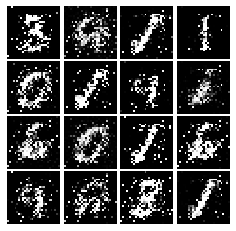

Epoch: 3, Iter: 1540, D: 0.1993, G:0.2437


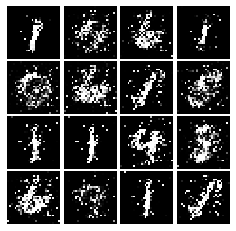

Epoch: 3, Iter: 1560, D: 0.1441, G:0.3736


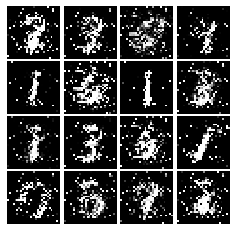

Epoch: 3, Iter: 1580, D: 0.1515, G:0.3453


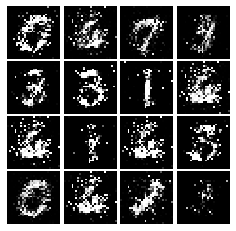

Epoch: 3, Iter: 1600, D: 0.1751, G:0.2826


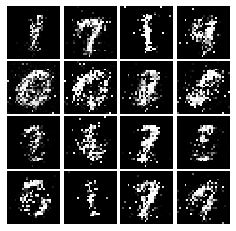

Epoch: 3, Iter: 1620, D: 0.1608, G:0.2791


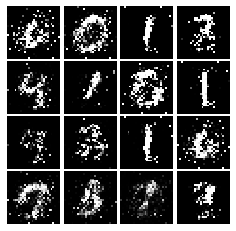

Epoch: 3, Iter: 1640, D: 0.1626, G:0.4149


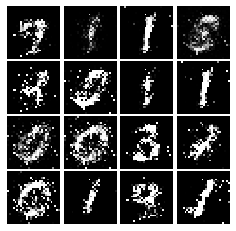

Epoch: 3, Iter: 1660, D: 0.1658, G:0.3166


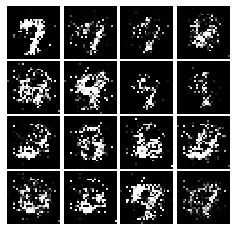

Epoch: 3, Iter: 1680, D: 0.174, G:0.3032


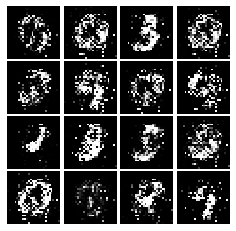

Epoch: 3, Iter: 1700, D: 0.1913, G:0.2015


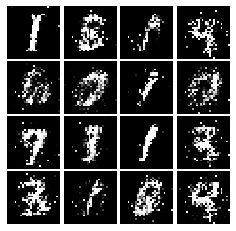

Epoch: 3, Iter: 1720, D: 0.1892, G:0.2052


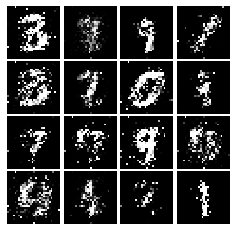

Epoch: 3, Iter: 1740, D: 0.1453, G:0.3059


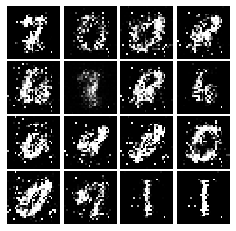

Epoch: 3, Iter: 1760, D: 0.1721, G:0.2449


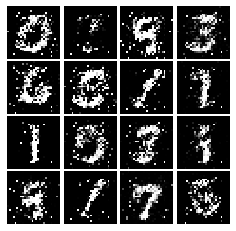

Epoch: 3, Iter: 1780, D: 0.1614, G:0.1944


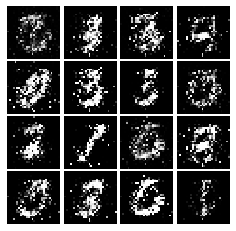

Epoch: 3, Iter: 1800, D: 0.2228, G:0.1886


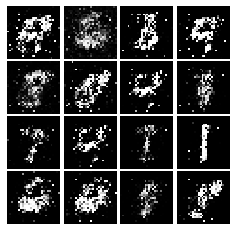

Epoch: 3, Iter: 1820, D: 0.1965, G:0.2663


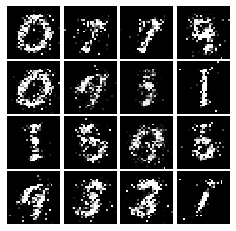

Epoch: 3, Iter: 1840, D: 0.19, G:0.235


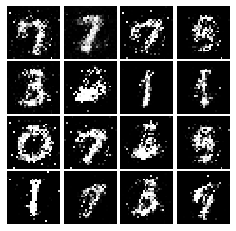

Epoch: 3, Iter: 1860, D: 0.2083, G:0.239


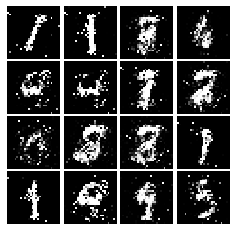

Epoch: 4, Iter: 1880, D: 0.2034, G:0.3573


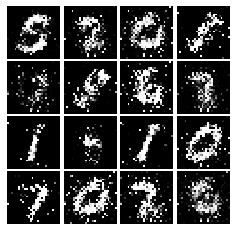

Epoch: 4, Iter: 1900, D: 0.2076, G:0.1945


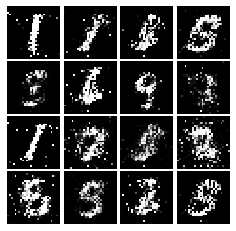

Epoch: 4, Iter: 1920, D: 0.2042, G:0.2102


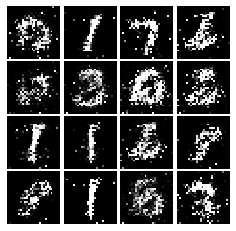

Epoch: 4, Iter: 1940, D: 0.2118, G:0.1794


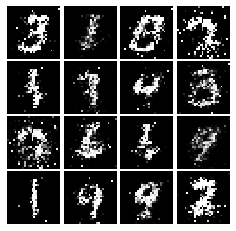

Epoch: 4, Iter: 1960, D: 0.1966, G:0.3043


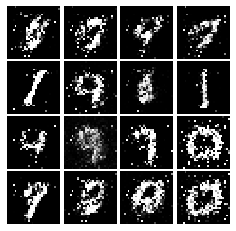

Epoch: 4, Iter: 1980, D: 0.1898, G:0.1772


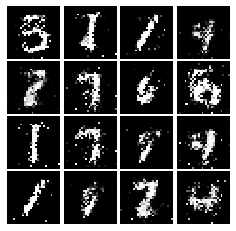

Epoch: 4, Iter: 2000, D: 0.2335, G:0.1776


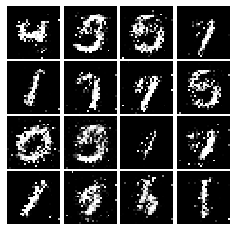

Epoch: 4, Iter: 2020, D: 0.227, G:0.2215


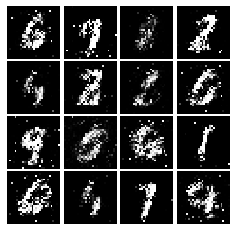

Epoch: 4, Iter: 2040, D: 0.2079, G:0.2384


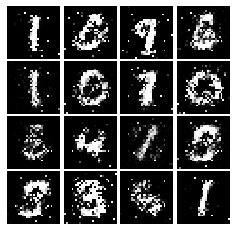

Epoch: 4, Iter: 2060, D: 0.2297, G:0.2102


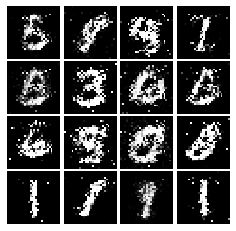

Epoch: 4, Iter: 2080, D: 0.208, G:0.22


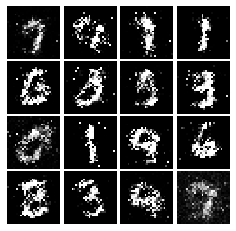

Epoch: 4, Iter: 2100, D: 0.2259, G:0.2171


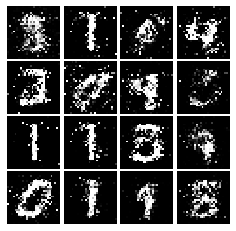

Epoch: 4, Iter: 2120, D: 0.2393, G:0.1763


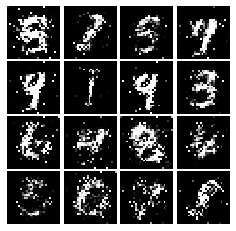

Epoch: 4, Iter: 2140, D: 0.2276, G:0.1854


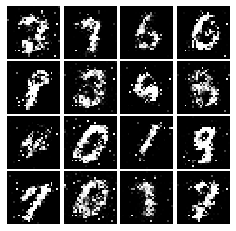

Epoch: 4, Iter: 2160, D: 0.2274, G:0.1775


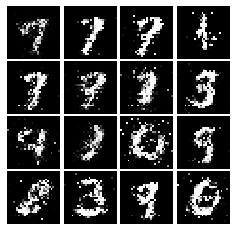

Epoch: 4, Iter: 2180, D: 0.2002, G:0.17


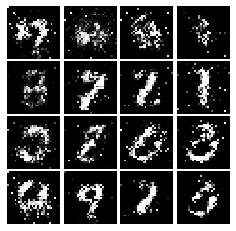

Epoch: 4, Iter: 2200, D: 0.1855, G:0.267


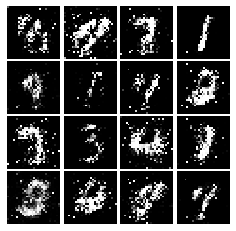

Epoch: 4, Iter: 2220, D: 0.2069, G:0.2104


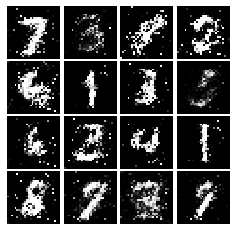

Epoch: 4, Iter: 2240, D: 0.1976, G:0.2212


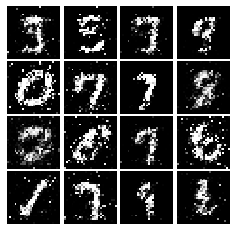

Epoch: 4, Iter: 2260, D: 0.1884, G:0.2192


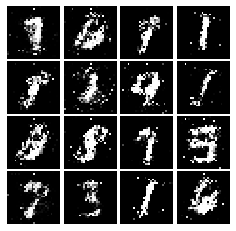

Epoch: 4, Iter: 2280, D: 0.188, G:0.1869


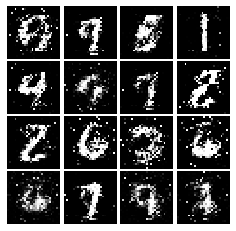

Epoch: 4, Iter: 2300, D: 0.2031, G:0.2303


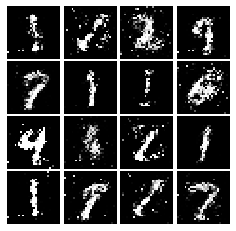

Epoch: 4, Iter: 2320, D: 0.1969, G:0.1743


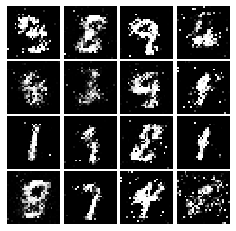

Epoch: 4, Iter: 2340, D: 0.1969, G:0.2643


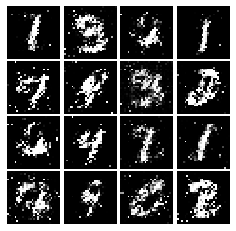

Epoch: 5, Iter: 2360, D: 0.186, G:0.2812


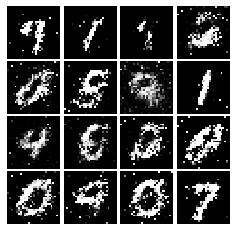

Epoch: 5, Iter: 2380, D: 0.2074, G:0.2026


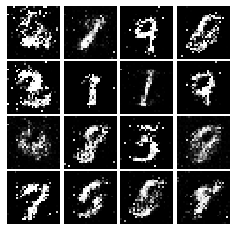

Epoch: 5, Iter: 2400, D: 0.1752, G:0.2133


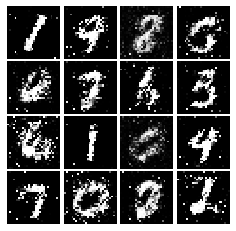

Epoch: 5, Iter: 2420, D: 0.2067, G:0.1901


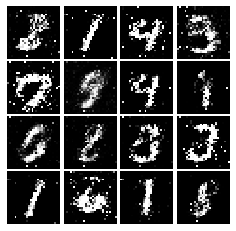

Epoch: 5, Iter: 2440, D: 0.2358, G:0.1678


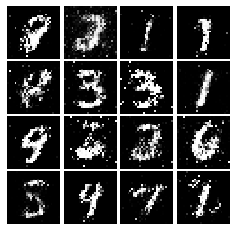

Epoch: 5, Iter: 2460, D: 0.1922, G:0.2239


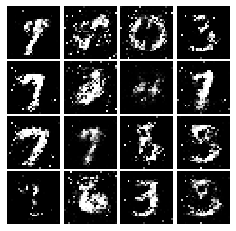

Epoch: 5, Iter: 2480, D: 0.1986, G:0.2346


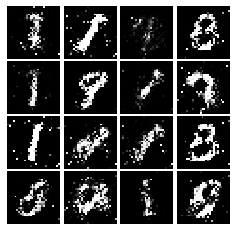

Epoch: 5, Iter: 2500, D: 0.2106, G:0.1802


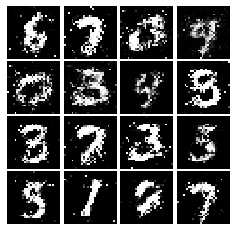

Epoch: 5, Iter: 2520, D: 0.2425, G:0.186


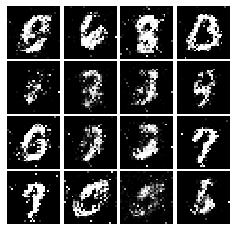

Epoch: 5, Iter: 2540, D: 0.2111, G:0.201


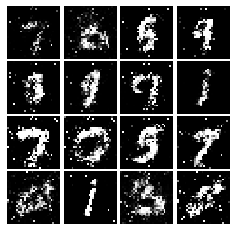

Epoch: 5, Iter: 2560, D: 0.2133, G:0.2403


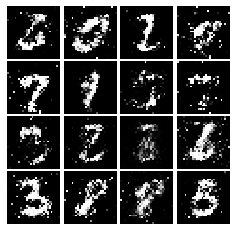

Epoch: 5, Iter: 2580, D: 0.1875, G:0.3043


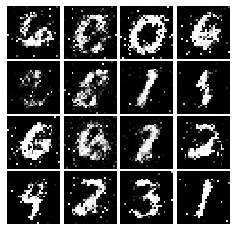

Epoch: 5, Iter: 2600, D: 0.2609, G:0.1714


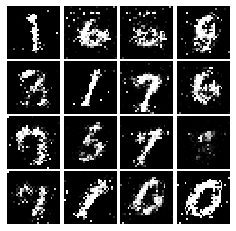

Epoch: 5, Iter: 2620, D: 0.2242, G:0.24


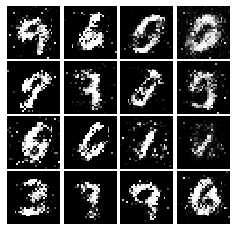

Epoch: 5, Iter: 2640, D: 0.221, G:0.1851


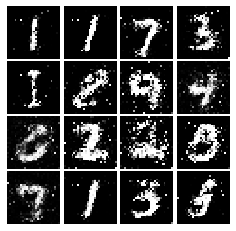

Epoch: 5, Iter: 2660, D: 0.2136, G:0.1983


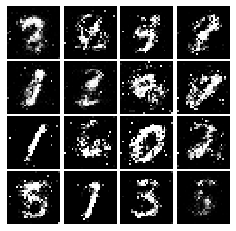

Epoch: 5, Iter: 2680, D: 0.2377, G:0.1878


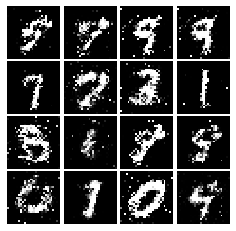

Epoch: 5, Iter: 2700, D: 0.2175, G:0.2165


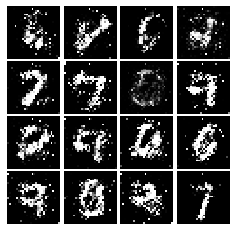

Epoch: 5, Iter: 2720, D: 0.2278, G:0.1717


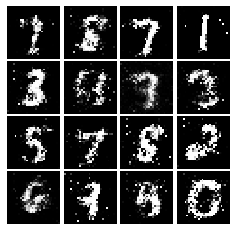

Epoch: 5, Iter: 2740, D: 0.2009, G:0.1926


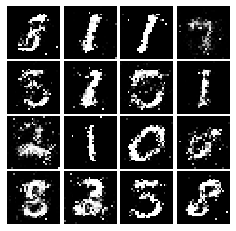

Epoch: 5, Iter: 2760, D: 0.2417, G:0.1666


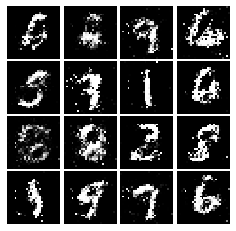

Epoch: 5, Iter: 2780, D: 0.2281, G:0.2047


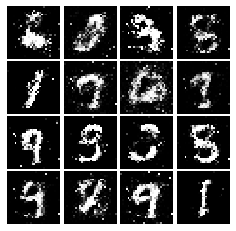

Epoch: 5, Iter: 2800, D: 0.2378, G:0.1895


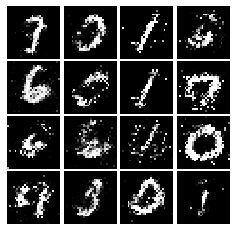

Epoch: 6, Iter: 2820, D: 0.2494, G:0.22


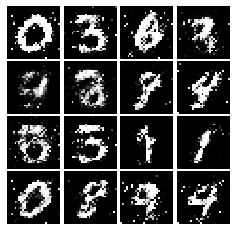

Epoch: 6, Iter: 2840, D: 0.2213, G:0.2384


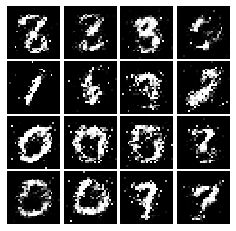

Epoch: 6, Iter: 2860, D: 0.1923, G:0.1933


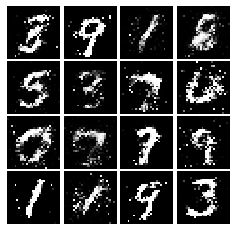

Epoch: 6, Iter: 2880, D: 0.2005, G:0.2148


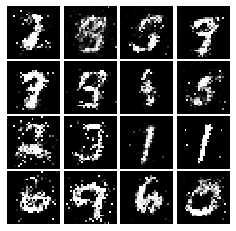

Epoch: 6, Iter: 2900, D: 0.2319, G:0.2067


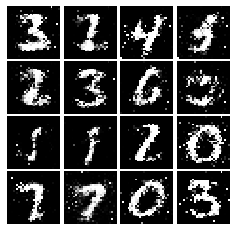

Epoch: 6, Iter: 2920, D: 0.2397, G:0.1903


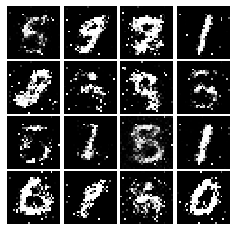

Epoch: 6, Iter: 2940, D: 0.222, G:0.1834


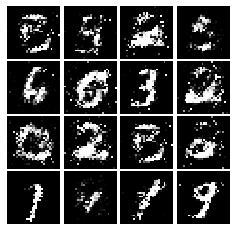

Epoch: 6, Iter: 2960, D: 0.2495, G:0.1833


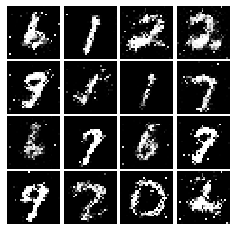

Epoch: 6, Iter: 2980, D: 0.2234, G:0.1674


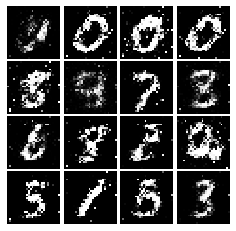

Epoch: 6, Iter: 3000, D: 0.2398, G:0.1963


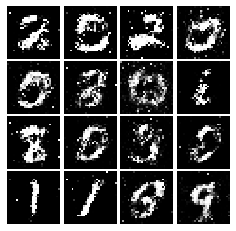

Epoch: 6, Iter: 3020, D: 0.2527, G:0.1742


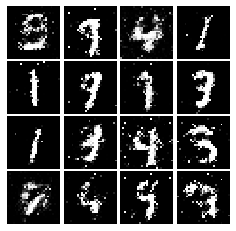

Epoch: 6, Iter: 3040, D: 0.2045, G:0.2067


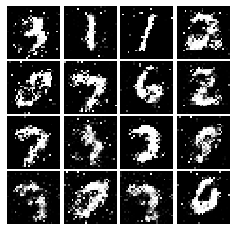

Epoch: 6, Iter: 3060, D: 0.2077, G:0.1677


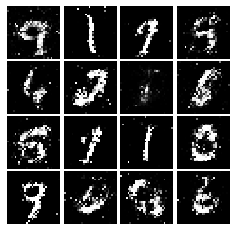

Epoch: 6, Iter: 3080, D: 0.2121, G:0.1906


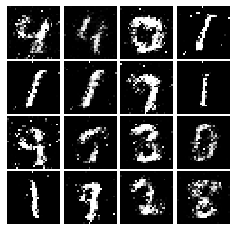

Epoch: 6, Iter: 3100, D: 0.1605, G:0.28


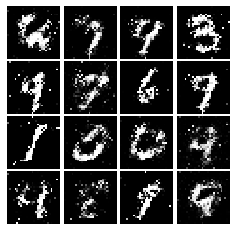

Epoch: 6, Iter: 3120, D: 0.2236, G:0.1678


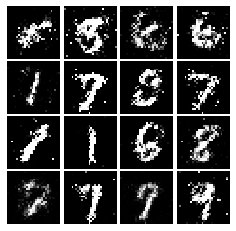

Epoch: 6, Iter: 3140, D: 0.2234, G:0.1602


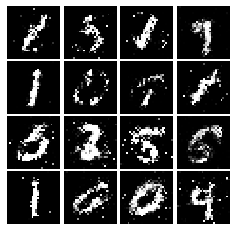

Epoch: 6, Iter: 3160, D: 0.1895, G:0.1925


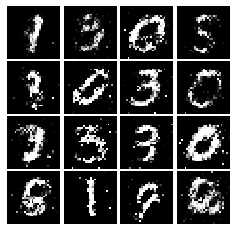

Epoch: 6, Iter: 3180, D: 0.2079, G:0.2039


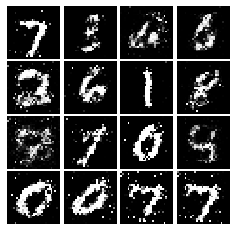

Epoch: 6, Iter: 3200, D: 0.2177, G:0.1993


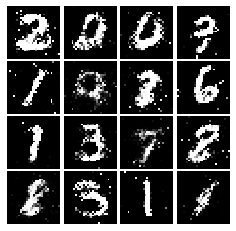

Epoch: 6, Iter: 3220, D: 0.2322, G:0.1757


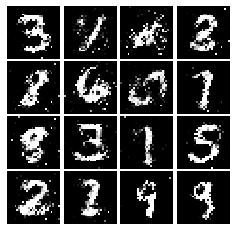

Epoch: 6, Iter: 3240, D: 0.206, G:0.1945


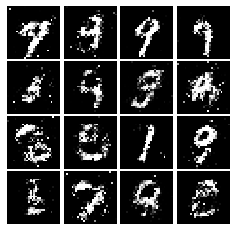

Epoch: 6, Iter: 3260, D: 0.2456, G:0.1797


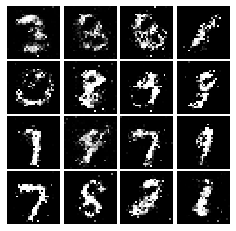

Epoch: 6, Iter: 3280, D: 0.2804, G:0.1688


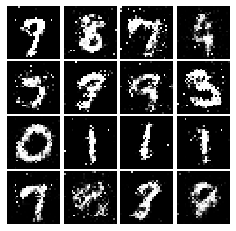

Epoch: 7, Iter: 3300, D: 0.1881, G:0.2126


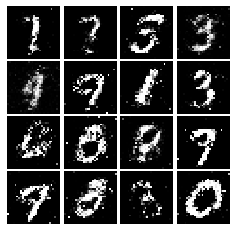

Epoch: 7, Iter: 3320, D: 0.1977, G:0.1766


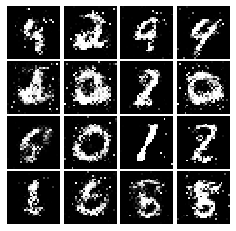

Epoch: 7, Iter: 3340, D: 0.2373, G:0.1656


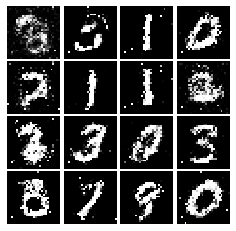

Epoch: 7, Iter: 3360, D: 0.2228, G:0.1829


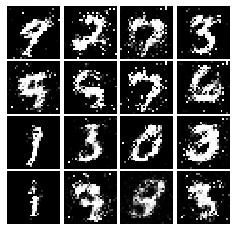

Epoch: 7, Iter: 3380, D: 0.2326, G:0.1784


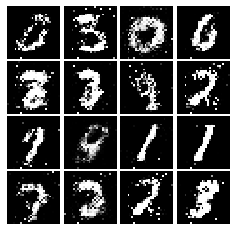

Epoch: 7, Iter: 3400, D: 0.2234, G:0.157


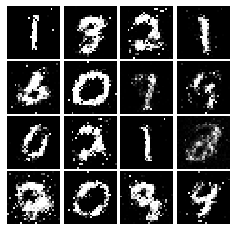

Epoch: 7, Iter: 3420, D: 0.2097, G:0.2157


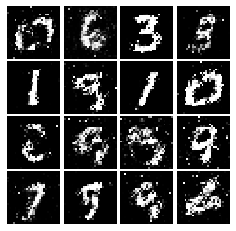

Epoch: 7, Iter: 3440, D: 0.2441, G:0.1811


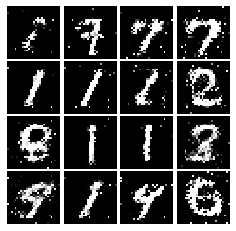

Epoch: 7, Iter: 3460, D: 0.1899, G:0.2027


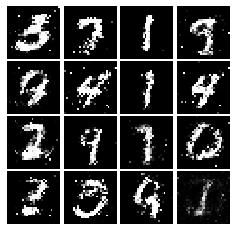

Epoch: 7, Iter: 3480, D: 0.2345, G:0.1521


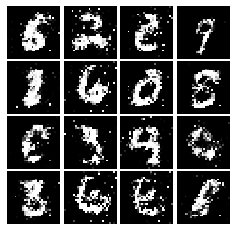

Epoch: 7, Iter: 3500, D: 0.2074, G:0.1556


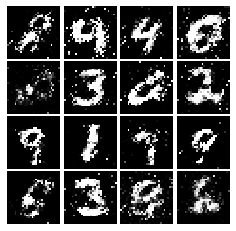

Epoch: 7, Iter: 3520, D: 0.2435, G:0.1615


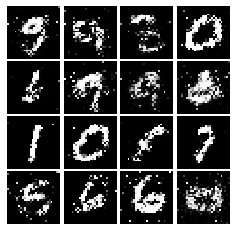

Epoch: 7, Iter: 3540, D: 0.205, G:0.1768


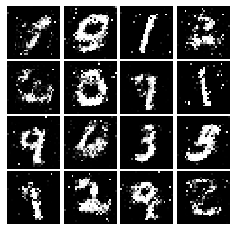

Epoch: 7, Iter: 3560, D: 0.206, G:0.1821


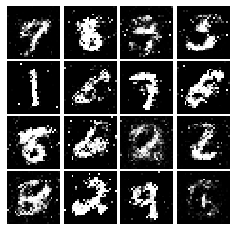

Epoch: 7, Iter: 3580, D: 0.2475, G:0.1868


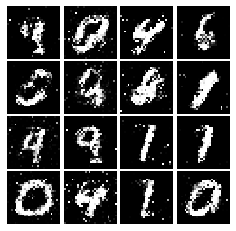

Epoch: 7, Iter: 3600, D: 0.2087, G:0.1822


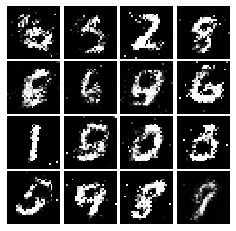

Epoch: 7, Iter: 3620, D: 0.2236, G:0.1619


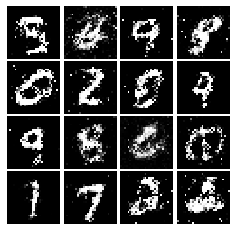

Epoch: 7, Iter: 3640, D: 0.2423, G:0.1611


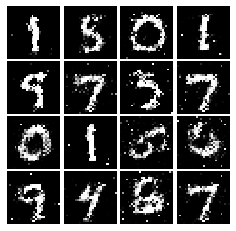

Epoch: 7, Iter: 3660, D: 0.2248, G:0.1676


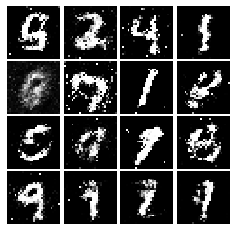

Epoch: 7, Iter: 3680, D: 0.2161, G:0.1819


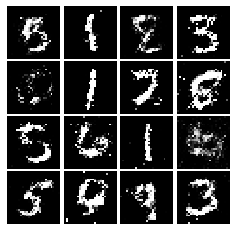

Epoch: 7, Iter: 3700, D: 0.2106, G:0.1905


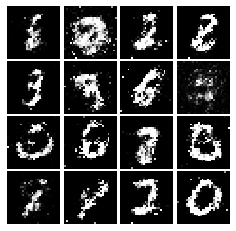

Epoch: 7, Iter: 3720, D: 0.2344, G:0.1776


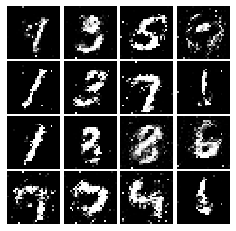

Epoch: 7, Iter: 3740, D: 0.2221, G:0.1745


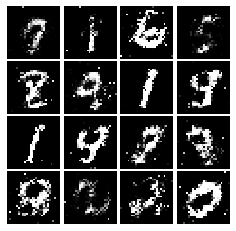

Epoch: 8, Iter: 3760, D: 0.2259, G:0.185


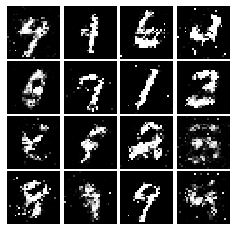

Epoch: 8, Iter: 3780, D: 0.2348, G:0.1919


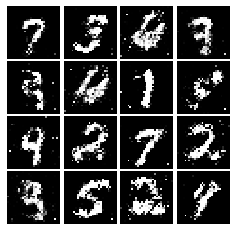

Epoch: 8, Iter: 3800, D: 0.2231, G:0.1841


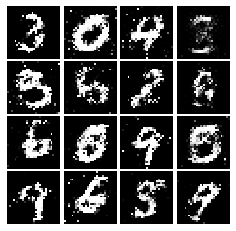

Epoch: 8, Iter: 3820, D: 0.2205, G:0.1952


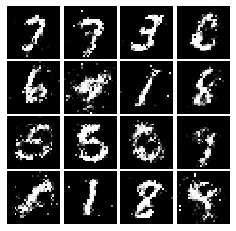

Epoch: 8, Iter: 3840, D: 0.2242, G:0.1748


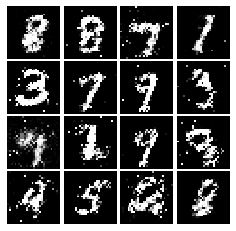

Epoch: 8, Iter: 3860, D: 0.2042, G:0.2063


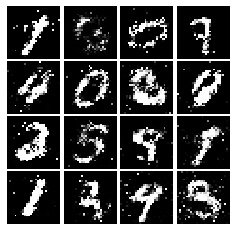

Epoch: 8, Iter: 3880, D: 0.2112, G:0.1479


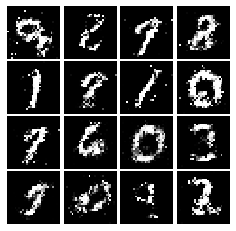

Epoch: 8, Iter: 3900, D: 0.2023, G:0.2053


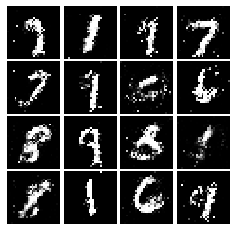

Epoch: 8, Iter: 3920, D: 0.2254, G:0.1765


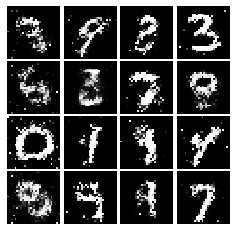

Epoch: 8, Iter: 3940, D: 0.2143, G:0.1967


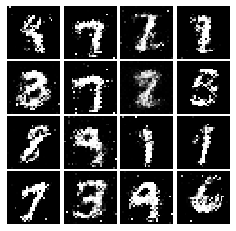

Epoch: 8, Iter: 3960, D: 0.2655, G:0.1681


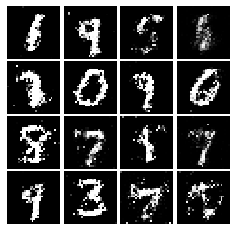

Epoch: 8, Iter: 3980, D: 0.2074, G:0.18


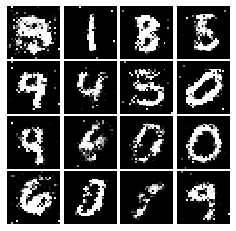

Epoch: 8, Iter: 4000, D: 0.222, G:0.1832


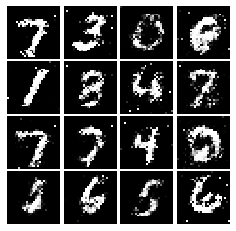

Epoch: 8, Iter: 4020, D: 0.2232, G:0.1666


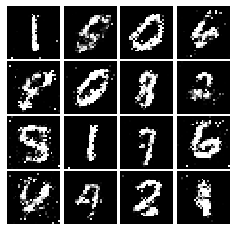

Epoch: 8, Iter: 4040, D: 0.2328, G:0.1599


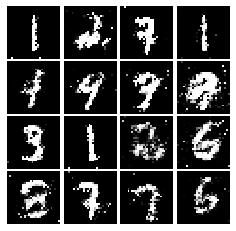

Epoch: 8, Iter: 4060, D: 0.2097, G:0.1971


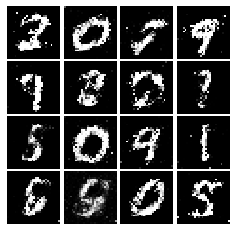

Epoch: 8, Iter: 4080, D: 0.2257, G:0.201


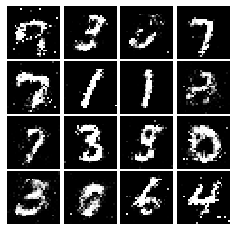

Epoch: 8, Iter: 4100, D: 0.2137, G:0.1756


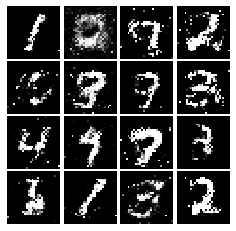

Epoch: 8, Iter: 4120, D: 0.2473, G:0.2002


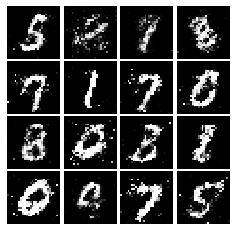

Epoch: 8, Iter: 4140, D: 0.2065, G:0.1948


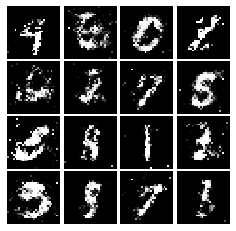

Epoch: 8, Iter: 4160, D: 0.2135, G:0.1883


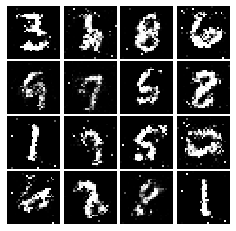

Epoch: 8, Iter: 4180, D: 0.2251, G:0.1744


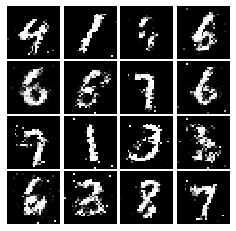

Epoch: 8, Iter: 4200, D: 0.221, G:0.1932


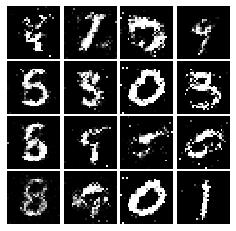

Epoch: 8, Iter: 4220, D: 0.2298, G:0.1745


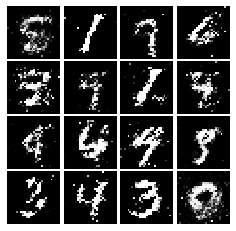

Epoch: 9, Iter: 4240, D: 0.2234, G:0.1815


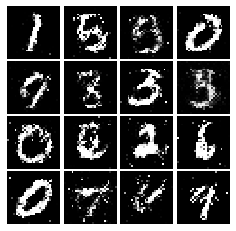

Epoch: 9, Iter: 4260, D: 0.2284, G:0.1648


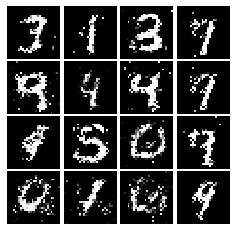

Epoch: 9, Iter: 4280, D: 0.2246, G:0.1936


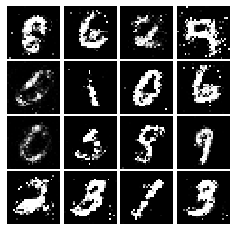

Epoch: 9, Iter: 4300, D: 0.2385, G:0.1699


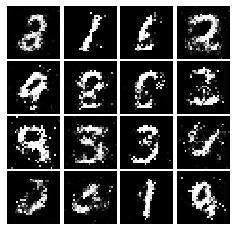

Epoch: 9, Iter: 4320, D: 0.2253, G:0.1994


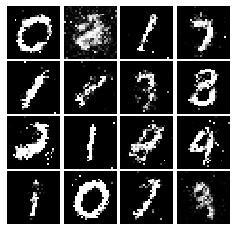

Epoch: 9, Iter: 4340, D: 0.2172, G:0.1634


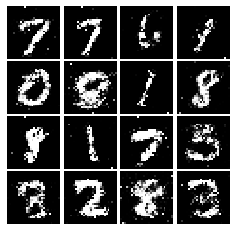

Epoch: 9, Iter: 4360, D: 0.2416, G:0.1936


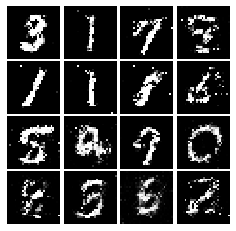

Epoch: 9, Iter: 4380, D: 0.2255, G:0.1526


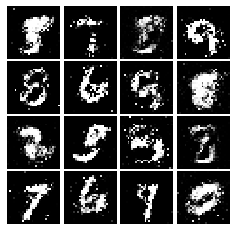

Epoch: 9, Iter: 4400, D: 0.2294, G:0.2037


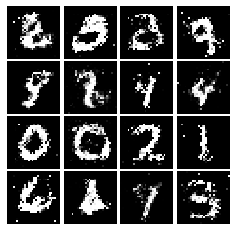

Epoch: 9, Iter: 4420, D: 0.2069, G:0.1865


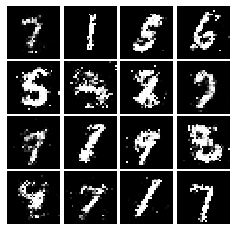

Epoch: 9, Iter: 4440, D: 0.221, G:0.1584


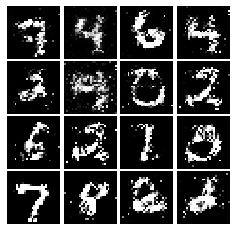

Epoch: 9, Iter: 4460, D: 0.2271, G:0.1655


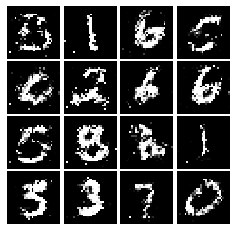

Epoch: 9, Iter: 4480, D: 0.2187, G:0.194


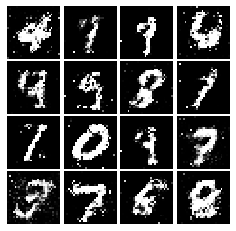

Epoch: 9, Iter: 4500, D: 0.2577, G:0.1893


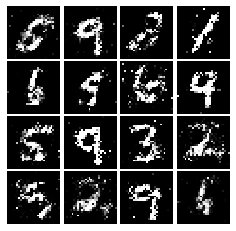

Epoch: 9, Iter: 4520, D: 0.2205, G:0.1818


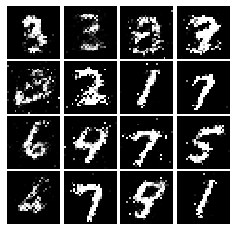

Epoch: 9, Iter: 4540, D: 0.2621, G:0.1822


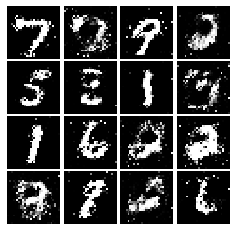

Epoch: 9, Iter: 4560, D: 0.2194, G:0.1679


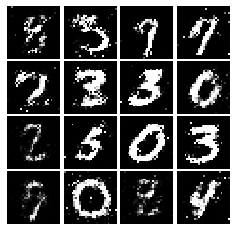

Epoch: 9, Iter: 4580, D: 0.2182, G:0.1792


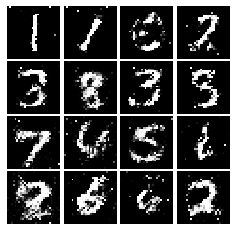

Epoch: 9, Iter: 4600, D: 0.2145, G:0.165


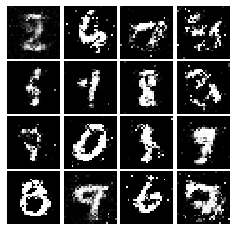

Epoch: 9, Iter: 4620, D: 0.2466, G:0.1496


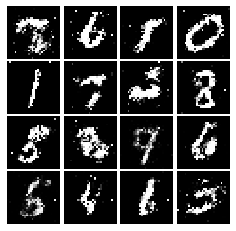

Epoch: 9, Iter: 4640, D: 0.2294, G:0.1662


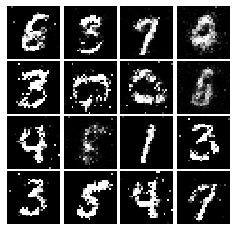

Epoch: 9, Iter: 4660, D: 0.2312, G:0.1584


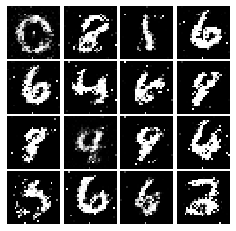

Epoch: 9, Iter: 4680, D: 0.2093, G:0.1748


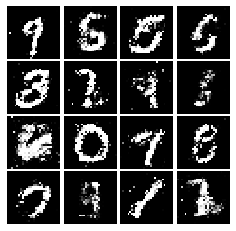

Final images


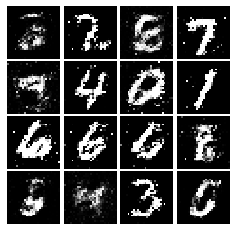

Elapsed:  283.1253607273102


In [20]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!

import time    
start = time.time()

run_a_gan(D, G, D_solver, G_solver, ls_discriminator_loss, ls_generator_loss)

end = time.time()
print("Elapsed: ", end - start)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.keras.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01) 
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [24]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(input_shape = (784,)),
        tf.keras.layers.Reshape((28, 28, 1)),
        tf.keras.layers.Conv2D(32, 5, padding = 'VALID', input_shape = (784,)),
        tf.keras.layers.LeakyReLU(alpha = .01),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Conv2D(64, 5, padding = 'VALID'),
        tf.keras.layers.LeakyReLU(alpha = .01),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Flatten(),
        
        
        tf.keras.layers.Dense(4 * 4 * 64),
        tf.keras.layers.LeakyReLU(alpha = .01),
        tf.keras.layers.Dense(1)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

model = discriminator()
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.keras.layers` for your implementation. You might find the documentation for [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [38]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
    # TODO: implement architecture
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    tf.keras.layers.Dense(1024, input_shape = (noise_dim,)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Reshape((7,7, 128)),

    tf.keras.layers.Conv2DTranspose(64, 4, strides=(2,2), padding = 'SAME'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),       

    tf.keras.layers.Conv2DTranspose(1, 4, strides=(2,2), padding = 'SAME', activation="tanh"),       

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])    
    return model

test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

Epoch: 0, Iter: 0, D: 1.358, G:0.6611


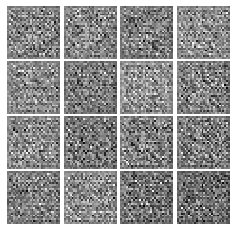

Epoch: 0, Iter: 20, D: 0.5521, G:1.773


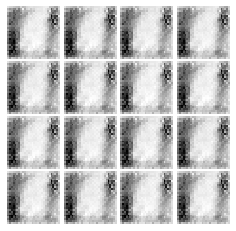

Epoch: 0, Iter: 40, D: 0.004056, G:5.626


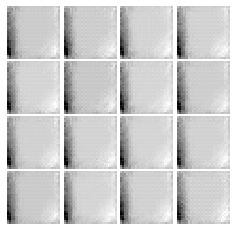

Epoch: 0, Iter: 60, D: 0.001086, G:6.898


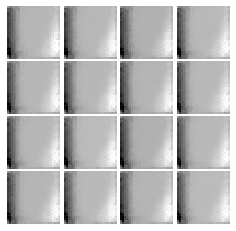

Epoch: 0, Iter: 80, D: 0.0002414, G:0.8014


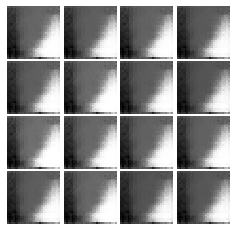

Epoch: 0, Iter: 100, D: 0.4802, G:4.576


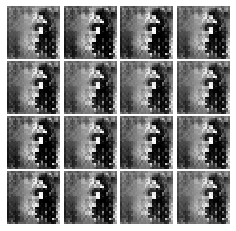

Epoch: 0, Iter: 120, D: 2.671, G:4.373


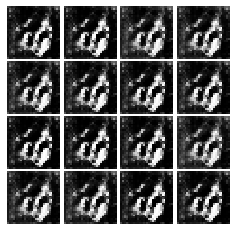

Epoch: 0, Iter: 140, D: 0.454, G:3.579


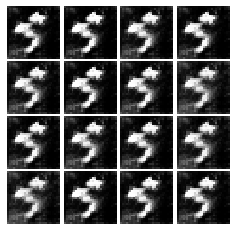

Epoch: 0, Iter: 160, D: 1.288, G:3.942


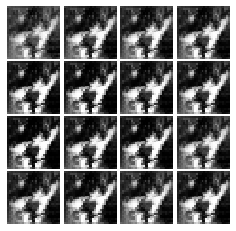

Epoch: 0, Iter: 180, D: 1.443, G:1.702


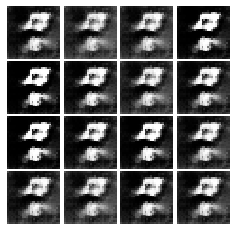

Epoch: 0, Iter: 200, D: 1.519, G:2.859


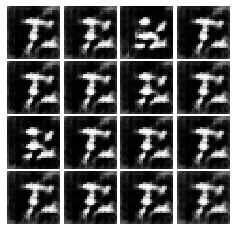

Epoch: 0, Iter: 220, D: 0.5956, G:3.121


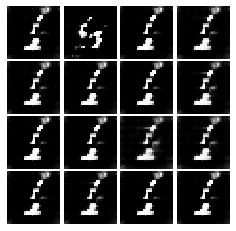

Epoch: 0, Iter: 240, D: 0.6862, G:1.898


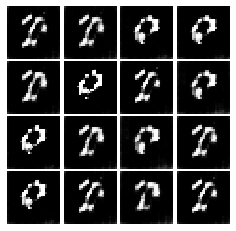

Epoch: 0, Iter: 260, D: 0.2793, G:2.737


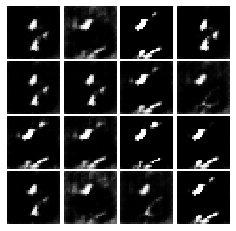

Epoch: 0, Iter: 280, D: 0.7108, G:2.061


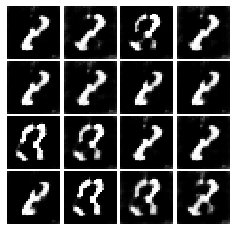

Epoch: 0, Iter: 300, D: 1.23, G:4.093


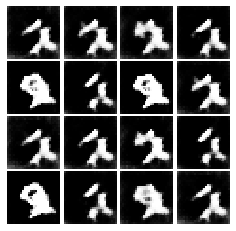

Epoch: 0, Iter: 320, D: 0.5212, G:2.453


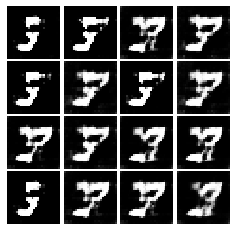

Epoch: 0, Iter: 340, D: 0.6359, G:1.779


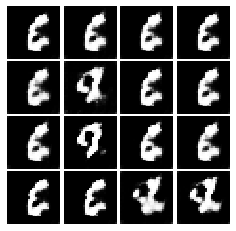

Epoch: 0, Iter: 360, D: 0.2046, G:3.246


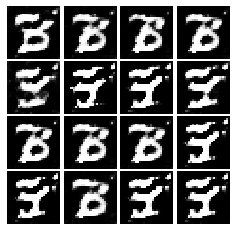

Epoch: 0, Iter: 380, D: 0.2255, G:4.427


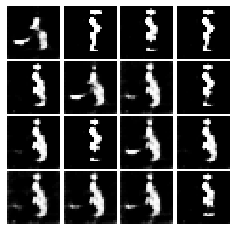

Epoch: 0, Iter: 400, D: 0.188, G:3.915


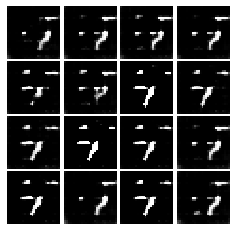

Epoch: 0, Iter: 420, D: 0.7196, G:2.807


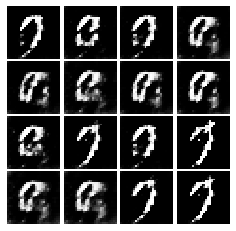

Epoch: 0, Iter: 440, D: 1.038, G:2.411


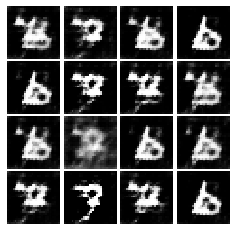

Epoch: 0, Iter: 460, D: 0.2344, G:4.302


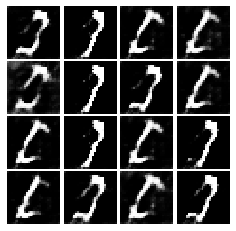

Epoch: 1, Iter: 480, D: 0.315, G:3.079


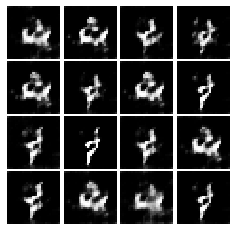

Epoch: 1, Iter: 500, D: 0.4488, G:3.827


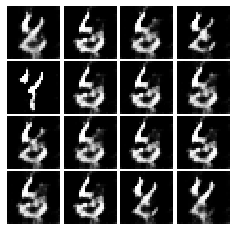

Epoch: 1, Iter: 520, D: 0.3551, G:4.949


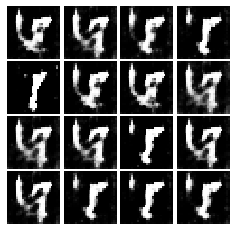

Epoch: 1, Iter: 540, D: 0.3841, G:3.286


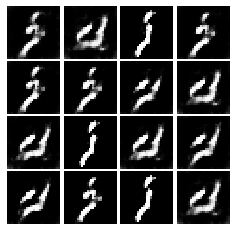

Epoch: 1, Iter: 560, D: 0.7568, G:2.53


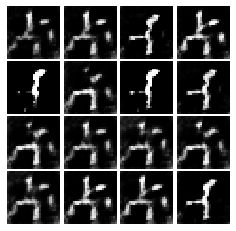

Epoch: 1, Iter: 580, D: 0.9686, G:2.417


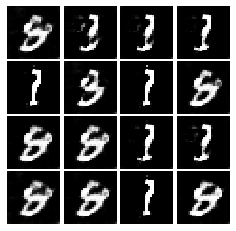

Epoch: 1, Iter: 600, D: 0.3627, G:3.389


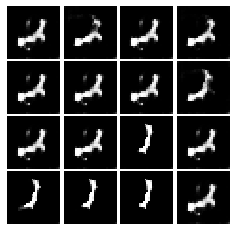

Epoch: 1, Iter: 620, D: 0.2106, G:3.923


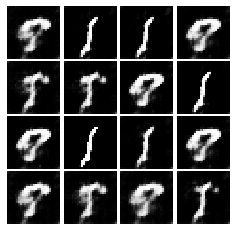

Epoch: 1, Iter: 640, D: 0.4653, G:5.289


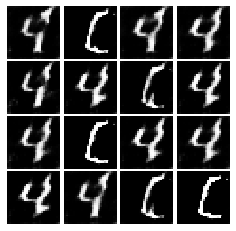

Epoch: 1, Iter: 660, D: 0.3859, G:3.903


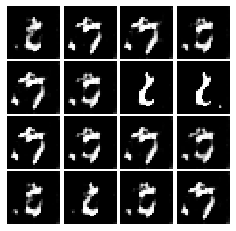

Epoch: 1, Iter: 680, D: 1.275, G:2.7


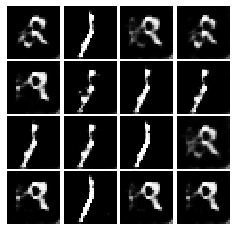

Epoch: 1, Iter: 700, D: 0.3409, G:2.337


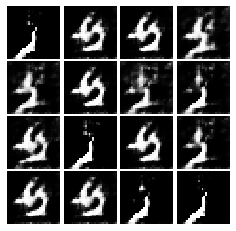

Epoch: 1, Iter: 720, D: 0.3346, G:3.474


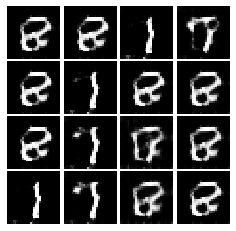

Epoch: 1, Iter: 740, D: 0.2854, G:3.034


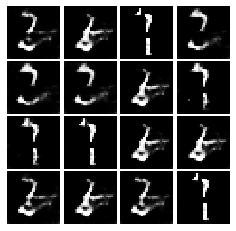

Epoch: 1, Iter: 760, D: 0.2806, G:4.241


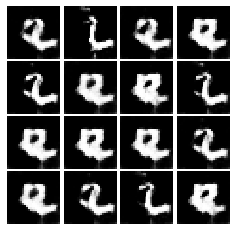

Epoch: 1, Iter: 780, D: 0.7175, G:4.16


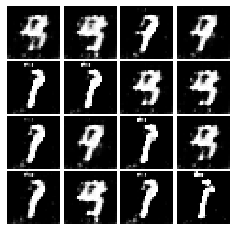

Epoch: 1, Iter: 800, D: 0.4287, G:3.409


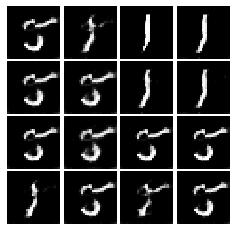

Epoch: 1, Iter: 820, D: 0.4135, G:3.858


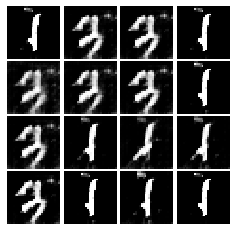

Epoch: 1, Iter: 840, D: 0.2599, G:4.045


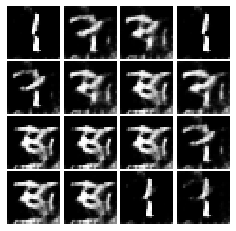

Epoch: 1, Iter: 860, D: 0.3268, G:3.574


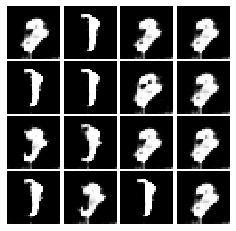

Epoch: 1, Iter: 880, D: 0.4315, G:3.48


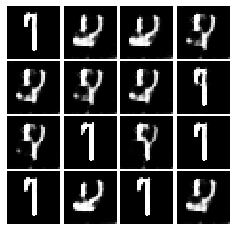

Epoch: 1, Iter: 900, D: 0.5662, G:5.157


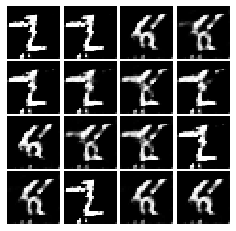

Epoch: 1, Iter: 920, D: 0.6366, G:2.246


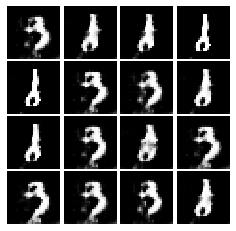

Epoch: 2, Iter: 940, D: 0.1155, G:3.99


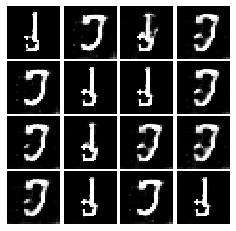

Epoch: 2, Iter: 960, D: 0.1481, G:3.962


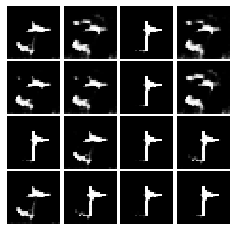

Epoch: 2, Iter: 980, D: 0.4823, G:3.386


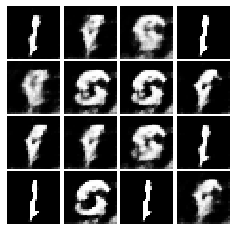

Epoch: 2, Iter: 1000, D: 0.3454, G:2.691


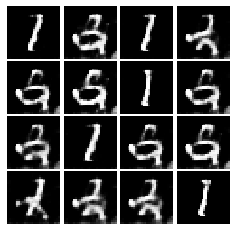

Epoch: 2, Iter: 1020, D: 0.1663, G:3.628


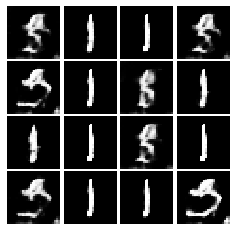

Epoch: 2, Iter: 1040, D: 0.2423, G:3.305


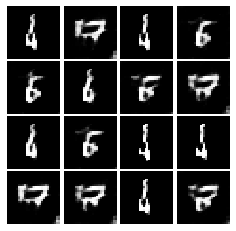

Epoch: 2, Iter: 1060, D: 0.1251, G:3.83


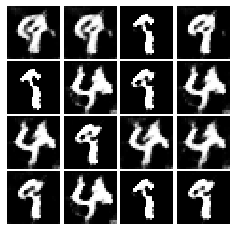

Epoch: 2, Iter: 1080, D: 0.3245, G:2.49


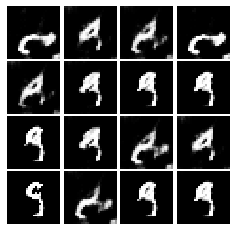

Epoch: 2, Iter: 1100, D: 0.3332, G:5.999


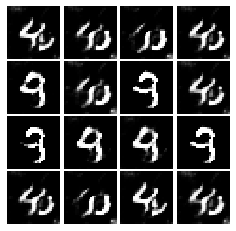

Epoch: 2, Iter: 1120, D: 0.1488, G:4.178


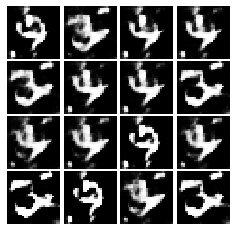

Epoch: 2, Iter: 1140, D: 0.3346, G:2.82


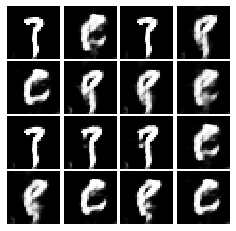

Epoch: 2, Iter: 1160, D: 0.5496, G:2.365


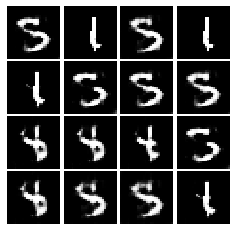

Epoch: 2, Iter: 1180, D: 0.309, G:3.677


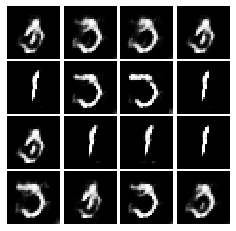

Epoch: 2, Iter: 1200, D: 0.4904, G:4.881


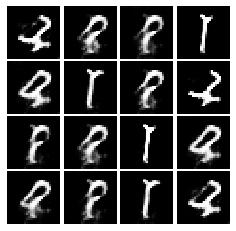

Epoch: 2, Iter: 1220, D: 0.4033, G:3.571


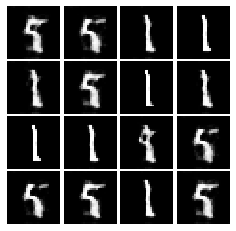

Epoch: 2, Iter: 1240, D: 0.2756, G:4.662


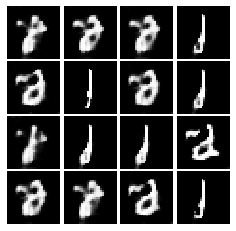

Epoch: 2, Iter: 1260, D: 0.5482, G:5.072


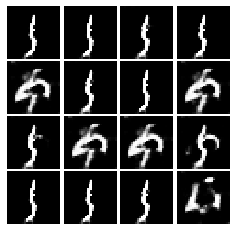

Epoch: 2, Iter: 1280, D: 0.4382, G:5.016


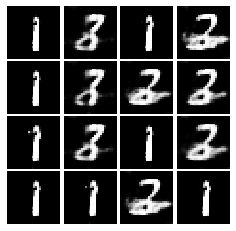

Epoch: 2, Iter: 1300, D: 0.09073, G:4.233


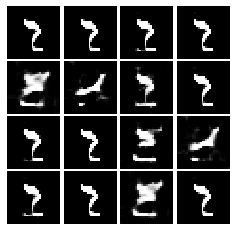

Epoch: 2, Iter: 1320, D: 0.4825, G:6.774


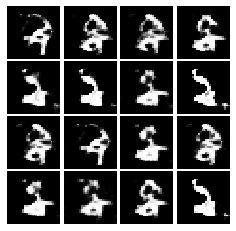

Epoch: 2, Iter: 1340, D: 0.2161, G:3.246


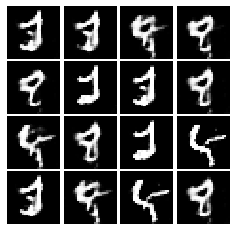

Epoch: 2, Iter: 1360, D: 0.2798, G:2.96


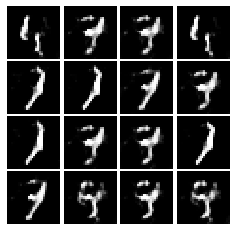

Epoch: 2, Iter: 1380, D: 0.1546, G:2.464


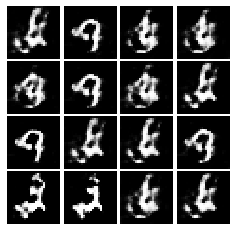

Epoch: 2, Iter: 1400, D: 0.1785, G:3.073


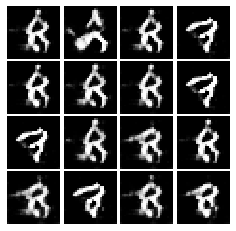

Epoch: 3, Iter: 1420, D: 0.1093, G:3.956


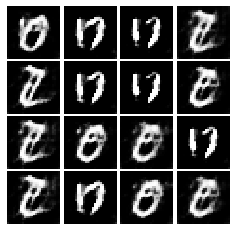

Epoch: 3, Iter: 1440, D: 0.1791, G:3.759


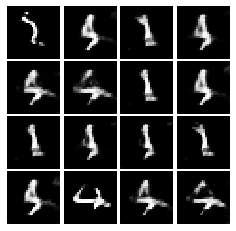

Epoch: 3, Iter: 1460, D: 0.2845, G:2.424


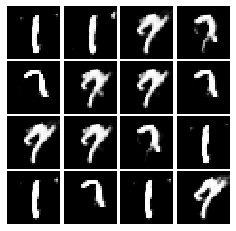

Epoch: 3, Iter: 1480, D: 0.2791, G:3.491


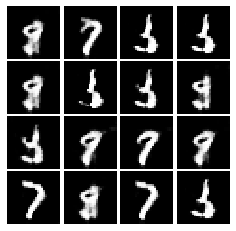

Epoch: 3, Iter: 1500, D: 0.4636, G:2.832


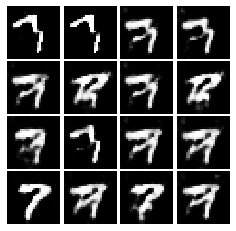

Epoch: 3, Iter: 1520, D: 3.284, G:4.205


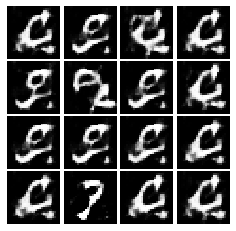

Epoch: 3, Iter: 1540, D: 0.2393, G:3.308


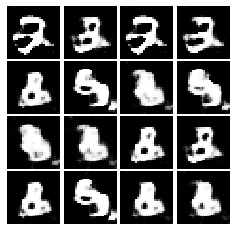

Epoch: 3, Iter: 1560, D: 0.5176, G:5.97


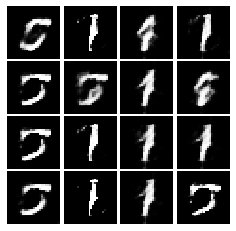

Epoch: 3, Iter: 1580, D: 0.1467, G:4.806


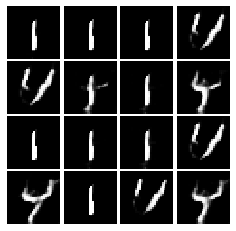

Epoch: 3, Iter: 1600, D: 0.1613, G:5.263


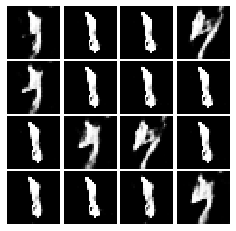

Epoch: 3, Iter: 1620, D: 0.1388, G:3.559


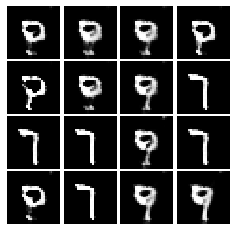

Epoch: 3, Iter: 1640, D: 0.08194, G:3.566


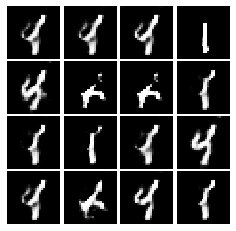

Epoch: 3, Iter: 1660, D: 0.3269, G:2.523


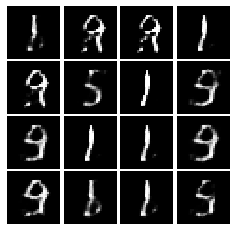

Epoch: 3, Iter: 1680, D: 0.3211, G:3.076


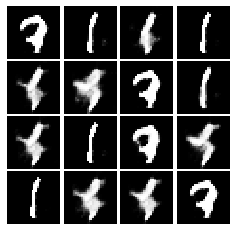

Epoch: 3, Iter: 1700, D: 0.3909, G:2.957


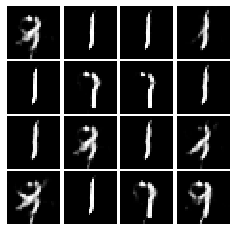

Epoch: 3, Iter: 1720, D: 0.4425, G:3.991


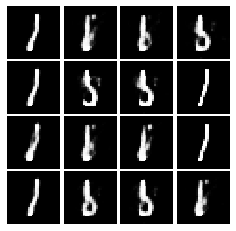

Epoch: 3, Iter: 1740, D: 0.7329, G:2.828


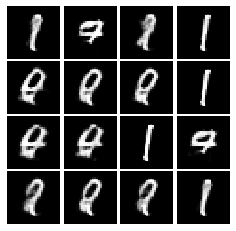

Epoch: 3, Iter: 1760, D: 0.4387, G:3.007


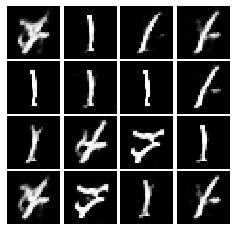

Epoch: 3, Iter: 1780, D: 0.3565, G:3.234


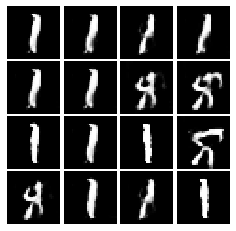

Epoch: 3, Iter: 1800, D: 0.3719, G:3.667


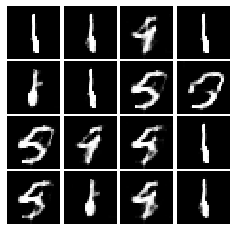

Epoch: 3, Iter: 1820, D: 0.1485, G:3.541


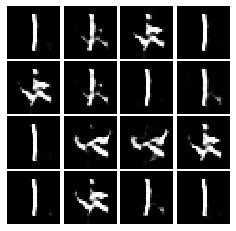

Epoch: 3, Iter: 1840, D: 0.2346, G:3.115


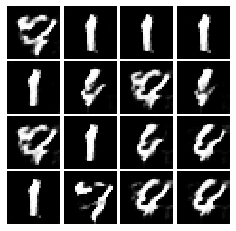

Epoch: 3, Iter: 1860, D: 0.4891, G:4.256


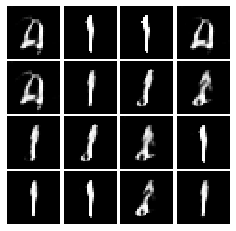

Epoch: 4, Iter: 1880, D: 0.3932, G:3.856


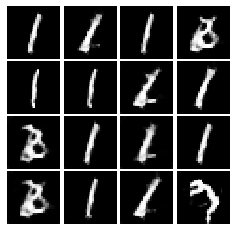

Epoch: 4, Iter: 1900, D: 0.2803, G:2.901


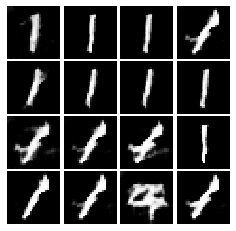

Epoch: 4, Iter: 1920, D: 0.509, G:2.286


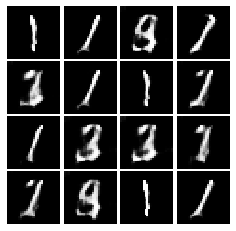

Epoch: 4, Iter: 1940, D: 0.3287, G:3.44


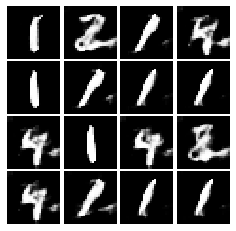

Epoch: 4, Iter: 1960, D: 0.7596, G:2.783


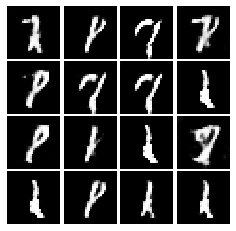

Epoch: 4, Iter: 1980, D: 0.1453, G:3.637


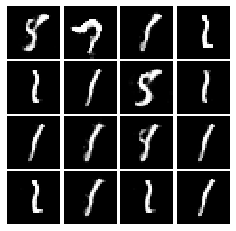

Epoch: 4, Iter: 2000, D: 0.4209, G:2.399


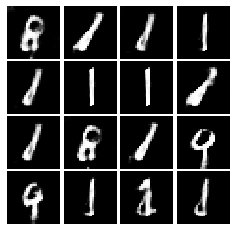

Epoch: 4, Iter: 2020, D: 0.5744, G:3.575


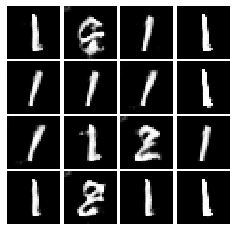

Epoch: 4, Iter: 2040, D: 0.4884, G:2.768


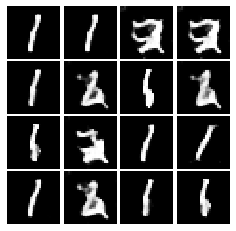

Epoch: 4, Iter: 2060, D: 0.2638, G:3.155


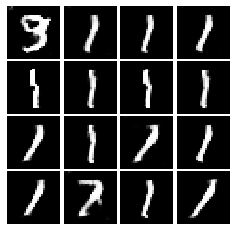

Epoch: 4, Iter: 2080, D: 0.2245, G:3.438


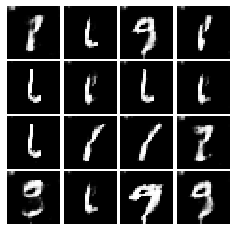

Epoch: 4, Iter: 2100, D: 0.2687, G:3.215


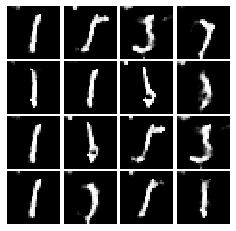

Epoch: 4, Iter: 2120, D: 0.4832, G:2.772


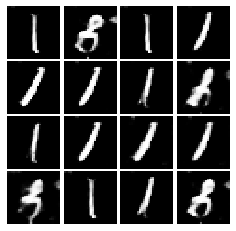

Epoch: 4, Iter: 2140, D: 0.5049, G:2.011


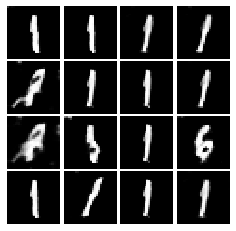

Epoch: 4, Iter: 2160, D: 0.4293, G:1.946


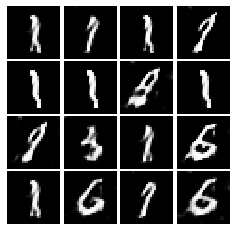

Epoch: 4, Iter: 2180, D: 0.238, G:3.874


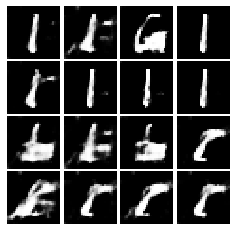

Epoch: 4, Iter: 2200, D: 0.3867, G:3.07


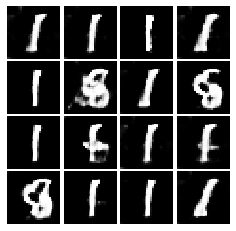

Epoch: 4, Iter: 2220, D: 0.3996, G:3.059


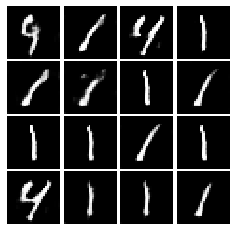

Epoch: 4, Iter: 2240, D: 0.4336, G:3.834


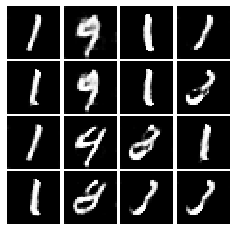

Epoch: 4, Iter: 2260, D: 0.3551, G:2.984


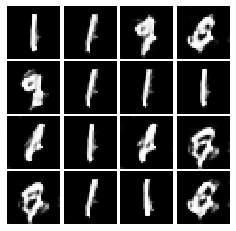

Epoch: 4, Iter: 2280, D: 0.4582, G:2.376


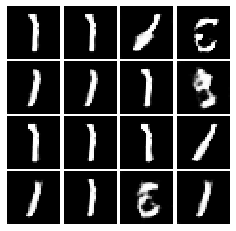

Epoch: 4, Iter: 2300, D: 0.3241, G:3.715


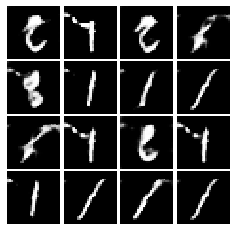

Epoch: 4, Iter: 2320, D: 0.4059, G:2.794


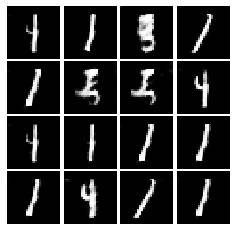

Epoch: 4, Iter: 2340, D: 0.4636, G:2.373


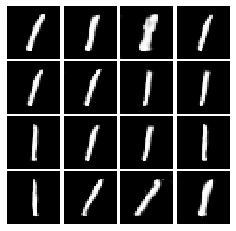

Final images


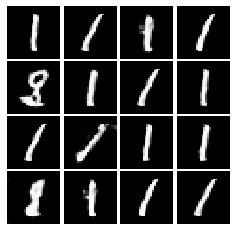

Elapsed:  313.4772529602051


In [42]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

import time    
start = time.time()
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs=5)

end = time.time()
print("Elapsed: ", end - start)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x using that updated y) with step size $1$. **Here step size is the learning_rate, and steps will be learning_rate * gradient.**
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Breifly explain what $\min_x\max_y f(x,y)$ evaluates to and record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |   2   |   1   |   -1  |   -2  |   -1  |  1     
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |   -1  |   -2  |   -1  |    1  |    2  |   1    
   


## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer: 

The values for a cycles, so they will never converge at all.


## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer: 

It's a good sign as long as the values converge, and in this case it means the generator is able to make "good" images that fool the descriminator.
